In [1]:
import pywt
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import numpy as np

In [2]:
#connect to sql
db_path = "../Database/thesis_database.db"
conn = sqlite3.connect(db_path)

In [18]:
#get data from sql
enso_mei_long = pd.read_sql_query("SELECT * FROM enso_mei", conn)

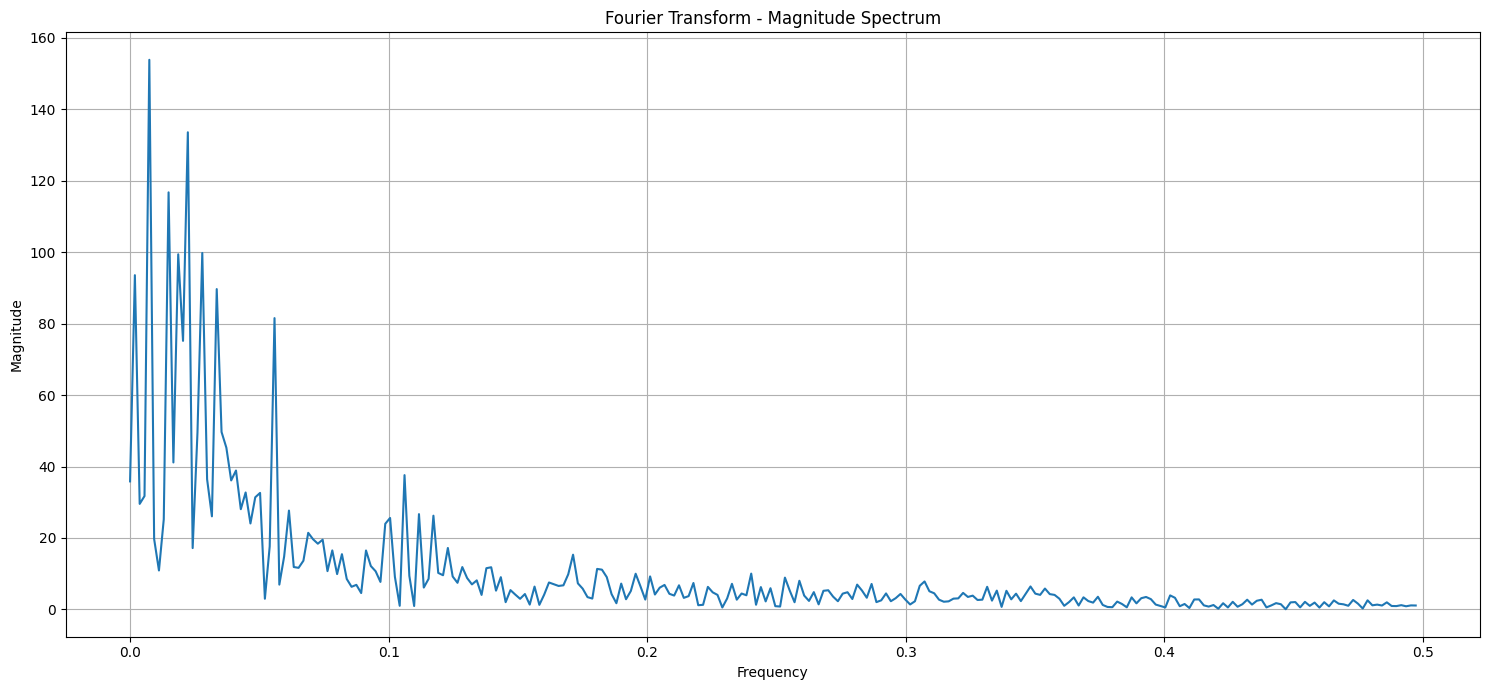

In [19]:
# Compute the Fourier transform of the MEI values
#Format Date to datetime %Y%m
enso_mei_long['Date'] = pd.to_datetime(enso_mei_long['Date'], format='%Y%m')
# Remove rows with NaN values
enso_mei_long_cleaned = enso_mei_long.dropna(subset=['MEI'])

# Extract the time (in months) and MEI values from the cleaned data
time_cleaned = np.arange(len(enso_mei_long_cleaned))
mei_values_cleaned = enso_mei_long_cleaned['MEI'].values
fft_values = np.fft.fft(mei_values_cleaned)
frequencies = np.fft.fftfreq(len(mei_values_cleaned))

# Plot the magnitude spectrum
plt.figure(figsize=(15, 7))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_values)[:len(frequencies)//2])
plt.title('Fourier Transform - Magnitude Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.show()

/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


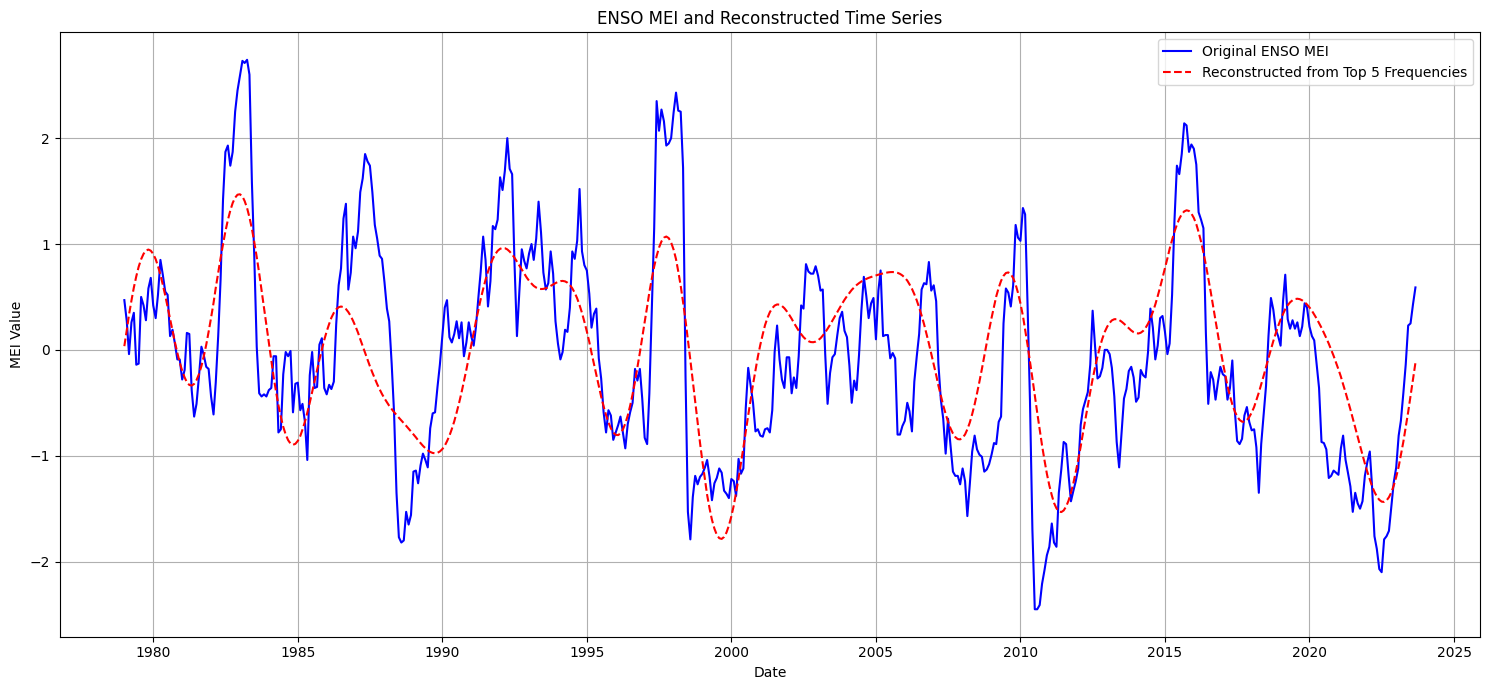

In [55]:
# Identify the top 5 dominant frequencies
top_n = 10
indices_sorted_by_magnitude = np.argsort(np.abs(fft_values))
top_indices = indices_sorted_by_magnitude[-top_n:]

# Zero out all frequencies except the top 5
filtered_fft_values = np.zeros_like(fft_values)
filtered_fft_values[top_indices] = fft_values[top_indices]

# Inverse Fourier transform to get the reconstructed time series
reconstructed_values = np.fft.ifft(filtered_fft_values)

# Plot the original and reconstructed time series
plt.figure(figsize=(15, 7))
plt.plot(enso_mei_long_cleaned['Date'], mei_values_cleaned, label='Original ENSO MEI', color='blue')
plt.plot(enso_mei_long_cleaned['Date'], reconstructed_values, label='Reconstructed from Top 5 Frequencies', color='red', linestyle='--')
plt.title('ENSO MEI and Reconstructed Time Series')
plt.xlabel('Date')
plt.ylabel('MEI Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
#  #Function to extend the Fourier components for forecasting
# def extend_fft(fft_values, forecast_months):
#     extended_fft = np.zeros(len(fft_values) + forecast_months)
#     middle_idx = len(fft_values) // 2
#     extended_fft[:middle_idx] = fft_values[:middle_idx]
#     extended_fft[-middle_idx:] = fft_values[-middle_idx:]
#     return extended_fft

In [ ]:
# # Define the time range for the extension: from 2020 to 2025
# start_date_2020 = pd.to_datetime("2020-01-01")
# end_date_2025 = pd.to_datetime("2025-12-31")
# forecast_period = pd.date_range(start_date_2020, end_date_2025, freq='M')

# # Determine the number of months to extend from the last available date in the original series to end of 2025
# extension_length = len(forecast_period) - len(mei_cleaned[mei_cleaned['Date'] >= start_date_2020])

# # Extend the Fourier components using the original top 10 dominant frequencies up to end of 2025
# extended_fft_2025 = extend_fft(filtered_fft_values, extension_length)

# # Inverse Fourier transform to get the time series extended up to 2025
# extended_scenario_2025 = np.fft.ifft(extended_fft_2025).real

# # Plot the original time series from 2020 and the forecasted portion of the extended scenario up to 2025
# plt.figure(figsize=(18, 9))
# plt.plot(mei_cleaned['Date'], mei_values_cleaned, label='Original ENSO MEI', color='blue')
# plt.plot(forecast_period, extended_scenario_2025, label='Extended Scenario (Up to 2025)', color='orange', linestyle='--')
# plt.title('ENSO MEI and Extended Scenario from 2020 to 2025')
# plt.xlabel('Date')
# plt.ylabel('MEI Value')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


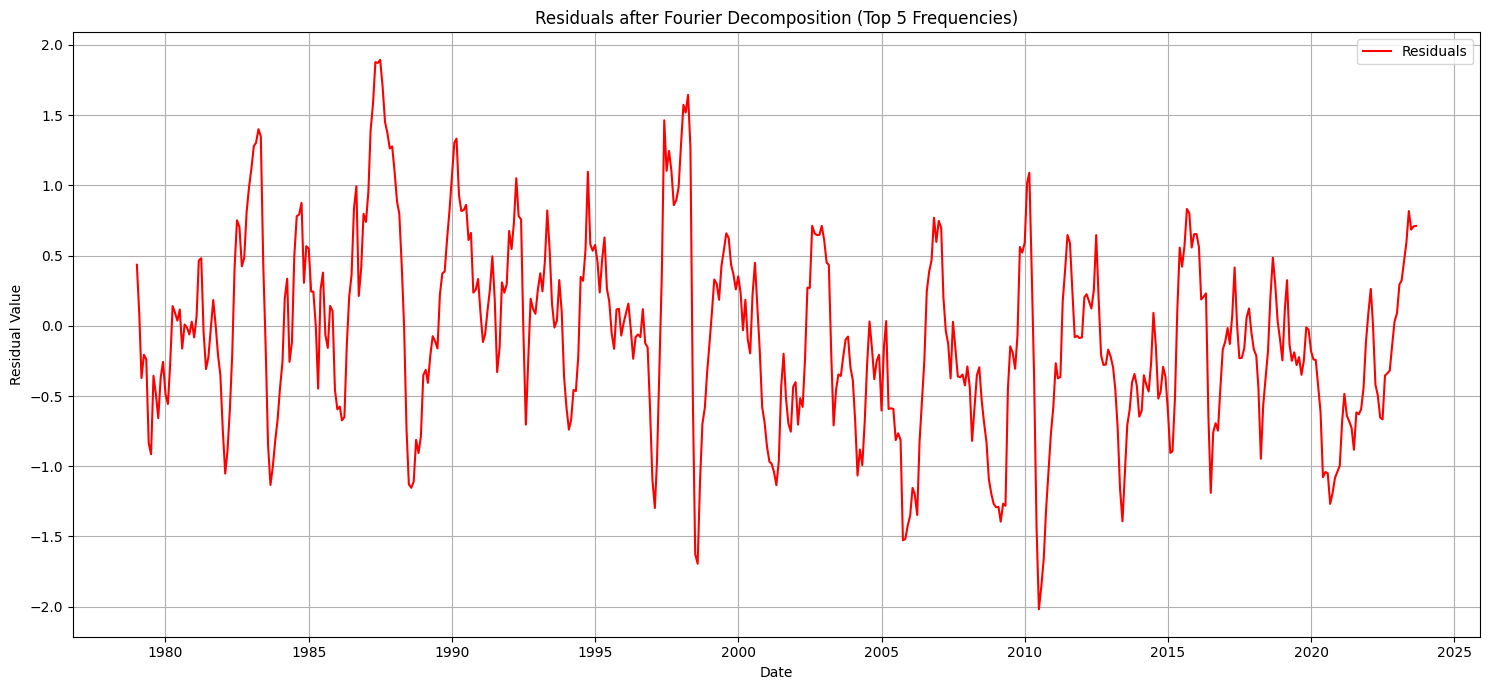

In [56]:
# Calculate the residuals from the Fourier decomposition using top 5 frequencies
fourier_reconstructed_10 = np.fft.ifft(filtered_fft_values).real
residuals_5_freq = mei_values_cleaned - fourier_reconstructed_10

# Plot the residuals
plt.figure(figsize=(15, 7))
plt.plot(enso_mei_long_cleaned['Date'], residuals_5_freq, label='Residuals', color='red')
plt.title('Residuals after Fourier Decomposition (Top 5 Frequencies)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
from arch import arch_model
# Fit a GARCH(1, 1) model to the residuals
garch_model = arch_model(residuals_5_freq, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
# Display the GARCH model summary
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -402.600
Distribution:                  Normal   AIC:                           813.200
Method:            Maximum Likelihood   BIC:                           830.344
                                        No. Observations:                  537
Date:                Mon, Oct 23 2023   Df Residuals:                      536
Time:                        19:04:48   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.0983  3.725e-02     -2.638  8.342e-03 [ -0.171,-2.525e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0482  1.244e-02      3.875  1.065e-04 [2.383e-02,7.259e-02]
alpha[1]       0.8284  6.805e-02     12.174  4.282e-34     [  0.695,  0.962]
beta[1]        0.1195  7.556e-02      1.582      0.114  [-2.859e-02,  0.268]
============================================================================

Covariance estimator: robust
"""

In [63]:
forecasts = garch_fit.forecast(start=0)
forecasted_values = forecasts.values.flatten()  # or any other range you're interested in
forecasted_values

/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


AttributeError: 'ARCHModelForecast' object has no attribute 'values'

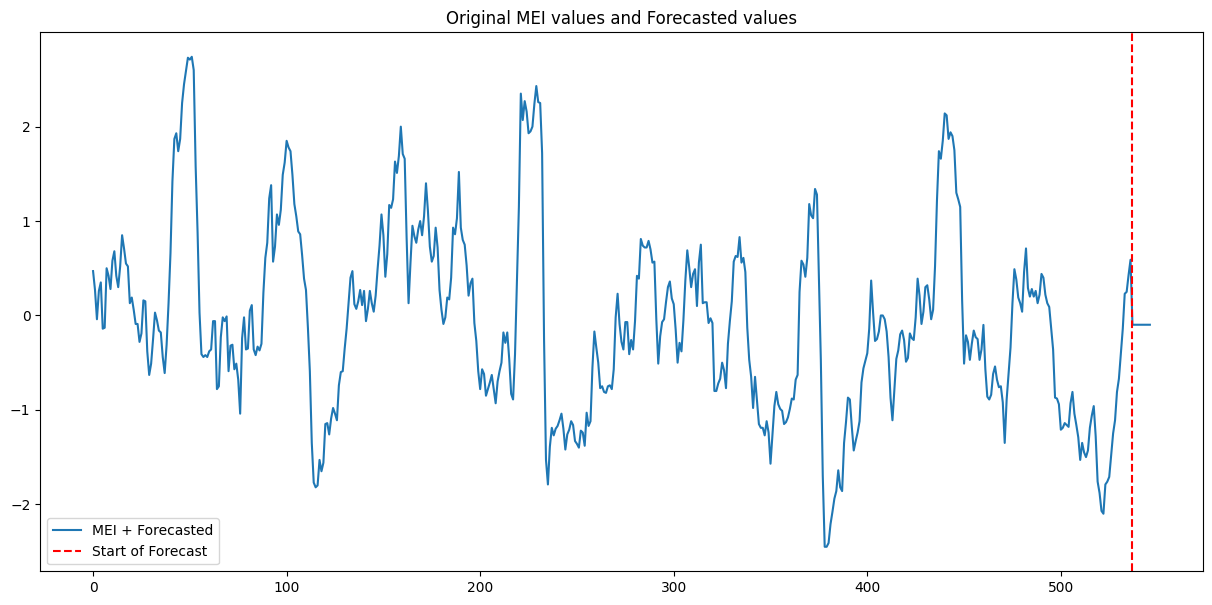

In [54]:
combined_series = np.concatenate((mei_values_cleaned, forecasted_values))
plt.figure(figsize=(15, 7))
plt.plot(combined_series, label='MEI + Forecasted')
plt.axvline(x=len(enso_mei_long_cleaned), color='red', linestyle='--', label='Start of Forecast')
plt.title('Original MEI values and Forecasted values')
plt.legend()
plt.show()